# RTP Forecasting

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
# Plot history and future
def plot_predictions(pred, actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred)), np.array(pred),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred)), np.array(actual),label='PF', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [63]:
# Plot history and future
def plot_predictions_slide(pred_1,pred_2,pred_3, actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(actual),label='PF', alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label='LSTM-24',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label='LSTM-48',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label='LSTM-27',alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [7]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [8]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [9]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [10]:
raw_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [11]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [12]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [13]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [14]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


# Trtaining the best model
After we did extensive search for the best hyperparameters, we will retrain the best model for set of lags (24, 48, 72), to see how it will perform on testing and have a fair comparison when comparing the other models (CNN, CNN-LSTM). 

### Lag = 24

#### Reshape to (samples, steps, features)

In [15]:
n_steps_in = 24
n_steps_out = 24

x_train_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape,y_train_lstm.shape,x_test_lstm.shape,y_test_lstm.shape)

(35017, 24, 3) (35017, 24, 1) (8713, 24, 3) (8713, 24, 1)


#### Tuned hyperparameters

In [16]:
# set hyperparameters (already tuned)
n_neuron       = 32
activation     = 'tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 32

#### Building the model

In [17]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train_lstm.shape[-2],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            4608      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 14,776
Trainable params: 14,776
Non-trainable params: 0
_________________________________________________________________


#### Running training

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(x_train_lstm, y_train_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
876/876 [==============================] - 15s 13ms/step - loss: 0.8362 - val_loss: 0.2141
Epoch 2/50
876/876 [==============================] - 11s 13ms/step - loss: 0.7046 - val_loss: 0.2064
Epoch 3/50
876/876 [==============================] - 12s 13ms/step - loss: 0.6729 - val_loss: 0.2041
Epoch 4/50
876/876 [==============================] - 12s 13ms/step - loss: 0.6712 - val_loss: 0.2062
Epoch 5/50
876/876 [==============================] - 13s 15ms/step - loss: 0.6491 - val_loss: 0.2042
Epoch 6/50
876/876 [==============================] - 14s 16ms/step - loss: 0.6519 - val_loss: 0.2058
Epoch 7/50
876/876 [==============================] - 14s 16ms/step - loss: 0.6410 - val_loss: 0.2057
Epoch 8/50
876/876 [==============================] - 12s 14ms/step - loss: 0.6426 - val_loss: 0.2051
Epoch 9/50
876/876 [==============================] - 11s 13ms/step - loss: 0.6326 - val_loss: 0.2017
Epoch 10/50
876/876 [==============================] - 11s 13ms/step - loss: 0.630

#### Saving the model

In [19]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model.save(os.path.join(model_path,'LSTM_model_best_24h.h5'))

y_test_pred_24 = lstm_model.predict(x_test_lstm)

### Lag = 48

In [20]:
n_steps_in = 48
n_steps_out = 24

x_train_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape,y_train_lstm.shape,x_test_lstm.shape,y_test_lstm.shape)

# set hyperparameters (already tuned)
n_neuron       = 32
activation     = 'tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 32

# Building the model
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train_lstm.shape[-2],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

# Running training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(x_train_lstm, y_train_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

# Saving the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model.save(os.path.join(model_path,'LSTM_model_best_48h.h5'))

y_test_pred_48 = lstm_model.predict(x_test_lstm)

(34993, 48, 3) (34993, 24, 1) (8689, 48, 3) (8689, 24, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 48, 32)            4608      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
Total params: 14,776
Trainable params: 14,776
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
875/875 [==============================] - 22s 22ms/step - loss: 0.8313 - val_loss: 0.2137
Epoch 2/50
875/875 [==

### Lag = 72

In [21]:
n_steps_in = 72
n_steps_out = 24

x_train_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape,y_train_lstm.shape,x_test_lstm.shape,y_test_lstm.shape)

# set hyperparameters (already tuned)
n_neuron       = 32
activation     = 'tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64

# Building the model
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train_lstm.shape[-2],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

# Running training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(x_train_lstm, y_train_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

# Saving the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model.save(os.path.join(model_path,'LSTM_model_best_72h.h5'))

y_test_pred_72 = lstm_model.predict(x_test_lstm)

(34969, 72, 3) (34969, 24, 1) (8665, 72, 3) (8665, 24, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 72, 32)            4608      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 24)                792       
                                                                 
Total params: 14,776
Trainable params: 14,776
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
438/438 [==============================] - 18s 34ms/step - loss: 0.8974 - val_loss: 0.2253
Epoch 2/50
438/438 [==

### Evaluate

In [24]:
n_steps_in = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_24h.h5'))
y_test_pred_24 = lstm_model.predict(x_test_lstm)

n_steps_in = 48
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_48 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_48h.h5'))
y_test_pred_48 = lstm_model.predict(x_test_lstm)

n_steps_in = 72
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_72 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_72h.h5'))
y_test_pred_72 = lstm_model.predict(x_test_lstm)


271/271 [==============================] - 3s 8ms/step


In [34]:
# Evaluation metrics
errors = y_test_pred_24 - y_test_lstm_24[:,:,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_48 - y_test_lstm_48[:,:,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_72 - y_test_lstm_72[:,:,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

print('Hour ahead only')
# Evaluation metrics for hour ahead only
errors = y_test_pred_24[:,0] - y_test_lstm_24[:,0,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_48[:,0] - y_test_lstm_48[:,0,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_72[:,0] - y_test_lstm_72[:,0,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

24h
MAE: 0.4591
RMSE: 0.7225

48h
MAE: 0.4752
RMSE: 0.7362

72h
MAE: 0.4509
RMSE: 0.7153

Hour ahead only
24h
MAE: 0.3452
RMSE: 0.5715

48h
MAE: 0.3639
RMSE: 0.5776

72h
MAE: 0.3540
RMSE: 0.5814


### Rescale and evaluate performance

In [32]:
y_test_pred_rescale_24 = y_test_pred_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_invlog_24 = np.exp(y_test_pred_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_rescale_48 = y_test_pred_48*y_std.values + y_mean.values
y_test_lstm_rescale_48 = y_test_lstm_48*y_std.values + y_mean.values
y_test_pred_invlog_48 = np.exp(y_test_pred_rescale_48) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_48 = np.exp(y_test_lstm_rescale_48) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_rescale_72 = y_test_pred_72*y_std.values + y_mean.values
y_test_lstm_rescale_72 = y_test_lstm_72*y_std.values + y_mean.values
y_test_pred_invlog_72 = np.exp(y_test_pred_rescale_72) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_72 = np.exp(y_test_lstm_rescale_72) -1 + min(raw_data.loc[:,"RTP"])

In [61]:
# Evaluation metrics
# 24 hours ahead
# Evaluation metrics
errors = y_test_pred_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_48 - y_test_lstm_invlog_48[:,:,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_72 - y_test_lstm_invlog_72[:,:,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

print('Hour ahead only')
# Evaluation metrics for hour ahead only
errors = y_test_pred_invlog_24[:,0] - y_test_lstm_invlog_24[:,0,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_48[:,0] - y_test_lstm_invlog_48[:,0,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_72[:,0] - y_test_lstm_invlog_72[:,0,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))


24h
MAE: 11.8169
RMSE: 22.1595

48h
MAE: 12.1817
RMSE: 22.3753

72h
MAE: 11.5954
RMSE: 22.0047

Hour ahead only
24h
MAE: 9.0775
RMSE: 18.5072

48h
MAE: 9.4821
RMSE: 18.6015

72h
MAE: 9.2481
RMSE: 18.6755


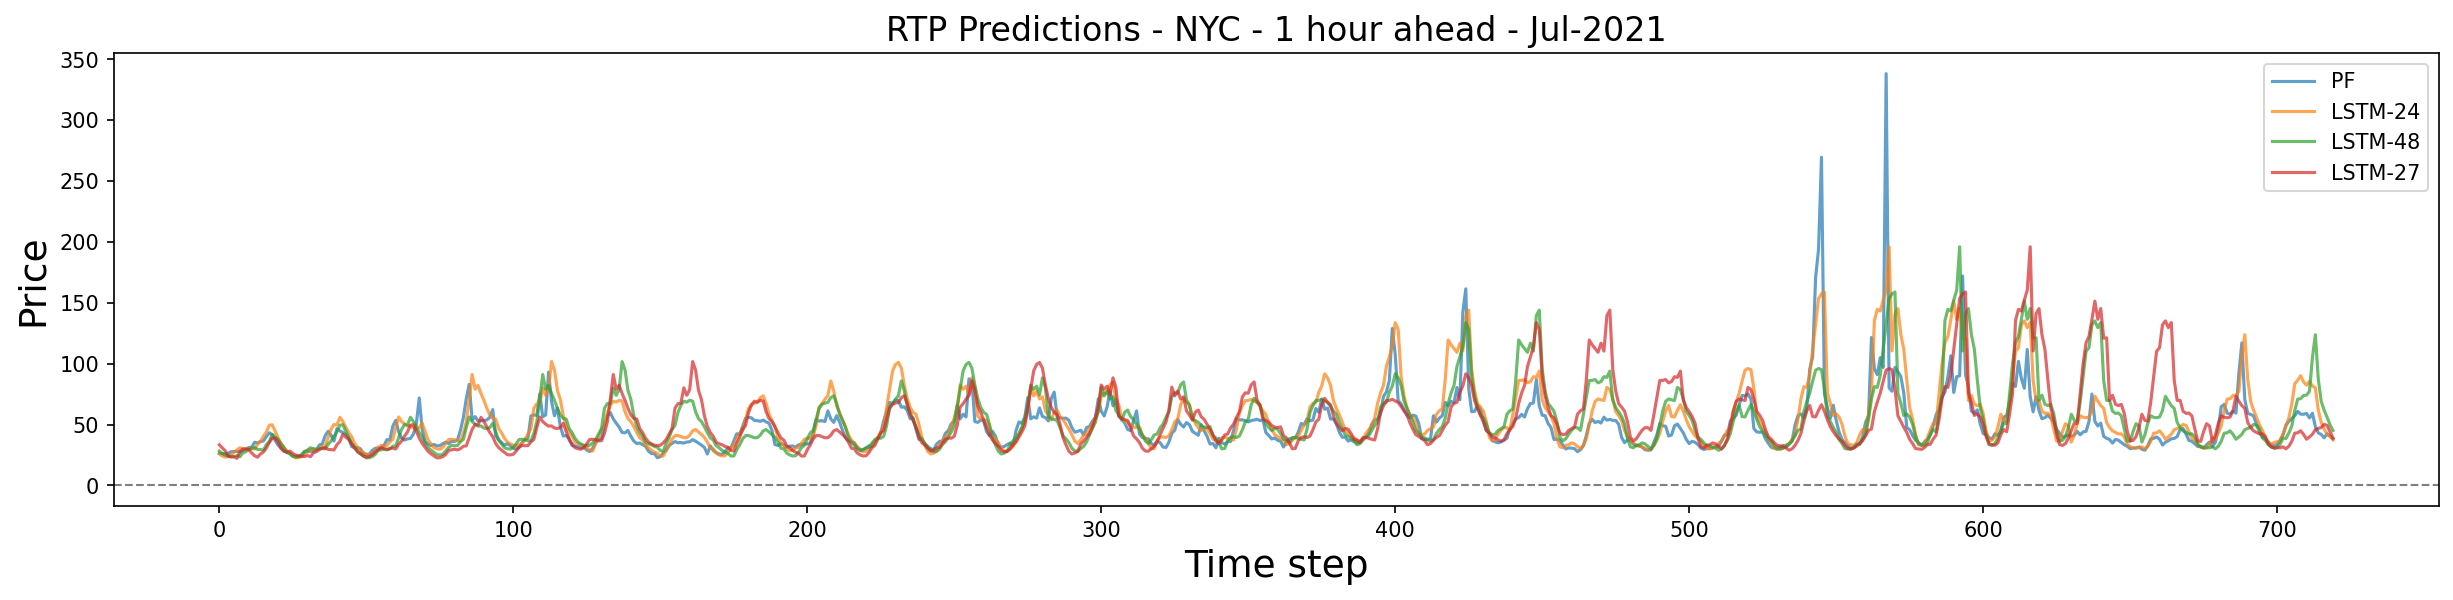

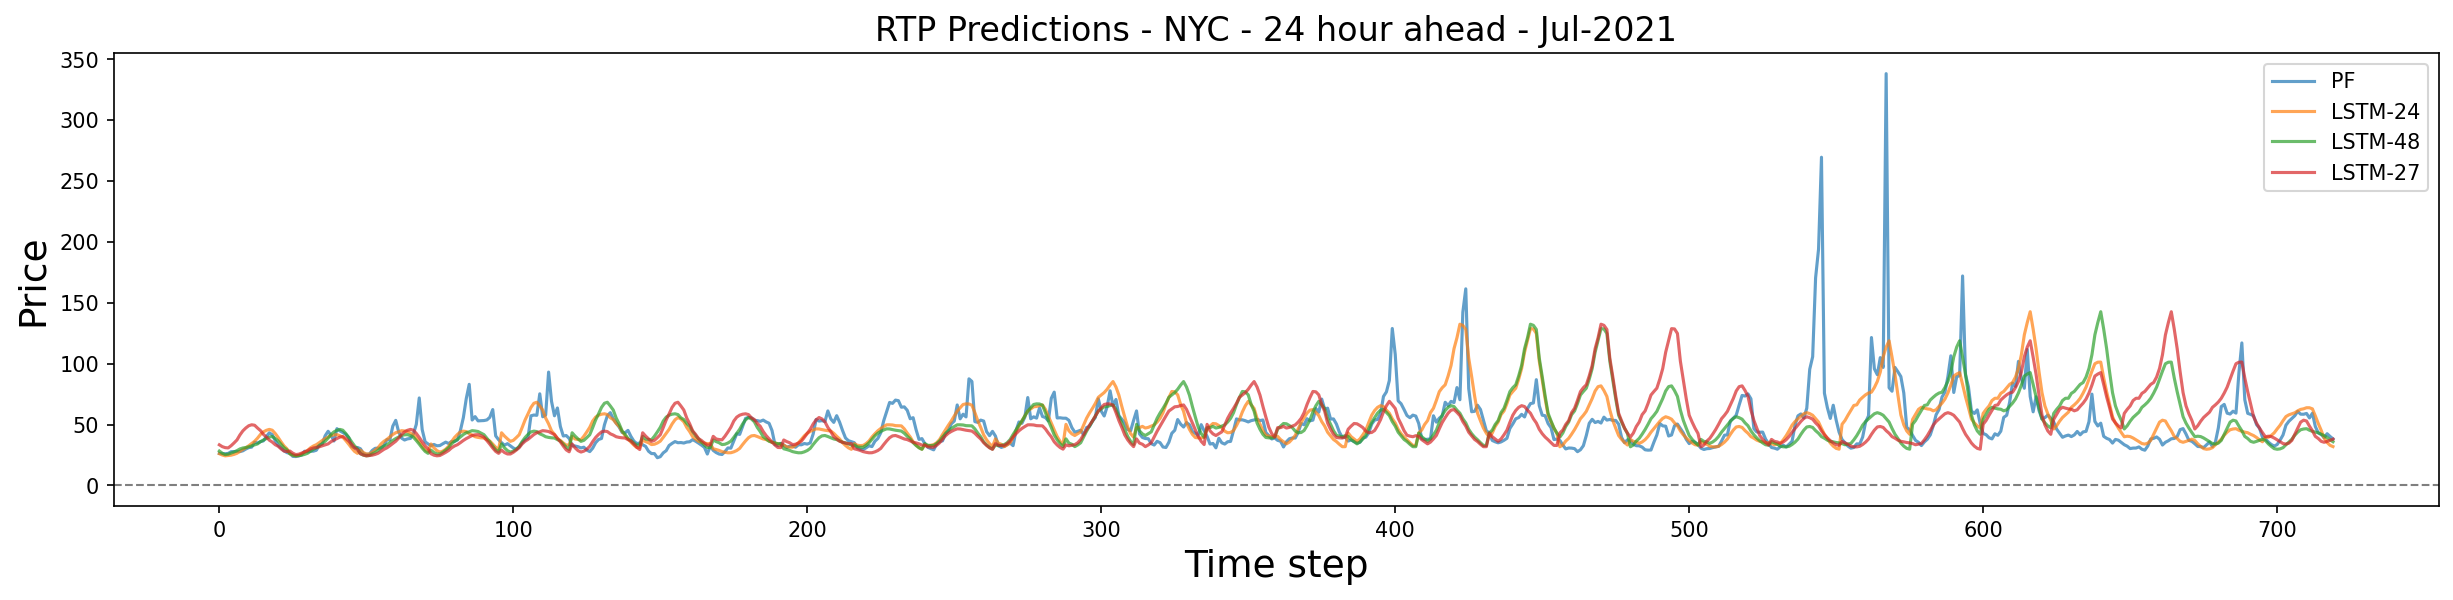

In [64]:
i = 7*24*30
j = i + 24*30

plot_predictions_slide(y_test_pred_invlog_24[i+48:j+48,0].flatten(),
                       y_test_pred_invlog_24[i+24:j+24,0].flatten(),
                       y_test_pred_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_72[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions_slide(y_test_pred_invlog_24[i+48:j+48:24,:].flatten(),
                       y_test_pred_invlog_24[i+24:j+24:24,:].flatten(),
                       y_test_pred_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_72[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021')
